In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import cv2
import time
import pickle
%matplotlib inline

In [2]:
path = '/home/ksaver/Desktop/GAN/celeba_2000/'

all_imgs = os.listdir(path)

In [3]:
paths = []
for i in all_imgs:
    paths.append(path + i)

In [4]:
imgs_bgr = []
for i in range(len(paths)):
    imgs_bgr.append(cv2.imread(paths[i], 1))

In [5]:
imgs_bgr = np.array(imgs_bgr)

In [6]:
imgs_bgr.shape

(2010, 64, 64, 3)

In [7]:
# bgr 2 rgb, for matplotlib

imgs = []

for i in imgs_bgr:
    imgs.append(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
    
imgs = np.array(imgs)

imgs.shape

(2010, 64, 64, 3)

In [8]:
# normalizing between -1 and 1
imgs_n = (imgs/127.5) - 1

In [9]:
#plotting 16 random images
def random_plotter(x):
    plt.figure(figsize = (15,15))
    for i in range(1,17):
        plt.subplot(4,4,i)
        plt.imshow(x[np.random.randint(0, len(x))])

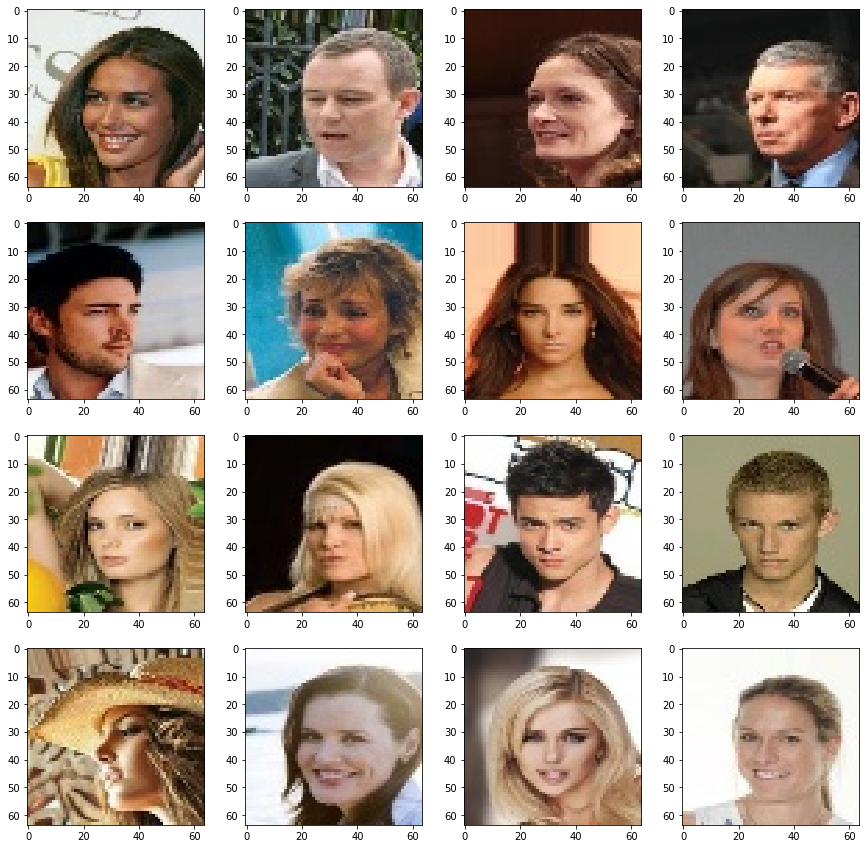

In [10]:
random_plotter(imgs)

#### Architecture taken from:

https://medium.com/dataminingwithmsitm/dcgan-playing-with-faces-tensorflow-2-0-27f8ae81b401

In [11]:
# setting constants
np.random.seed(10)

noise_dim = 100

batch_size = 32
steps_per_epoch = 60
epochs = 10

optimizer = keras.optimizers.Adam(0.0002, 0.5)

In [12]:
# generator

generator = keras.models.Sequential([
    # 4x4
    keras.layers.Dense(4*4*1024),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    keras.layers.Reshape((4,4,1024)),
    # 8x8
    keras.layers.Conv2DTranspose(512, kernel_size = 5, padding='same', strides=2),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    #16x16
    keras.layers.Conv2DTranspose(256, kernel_size = 5, padding='same', strides=2),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    # 32x32
    keras.layers.Conv2DTranspose(128, kernel_size = 5, padding = 'same', strides=2),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    #64x64x3
    keras.layers.Conv2DTranspose(3, kernel_size=5, padding='same', strides=2, activation='tanh')
])


generator.compile(loss = 'binary_crossentropy', optimizer=optimizer)

In [13]:
#discriminator

discriminator = keras.models.Sequential([
    #64x64
    keras.layers.Input(shape=(64,64,3)),
    #32x32
    keras.layers.Conv2DTranspose(64, kernel_size=5, padding='same', strides=2),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.25),
    #16x16
    keras.layers.Conv2D(128, kernel_size=5, padding='same', strides=2),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.25),
    #flatten
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])


discriminator.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics = ['accuracy'])

# setting trainable to false

discriminator.trainable = False

In [14]:
# whole gan

gan_input = keras.layers.Input(shape=noise_dim,)
fake_img = generator(gan_input)
gan_output = discriminator(fake_img)
gan = keras.Model(gan_input, gan_output)

gan.compile(loss = 'binary_crossentropy', optimizer=optimizer)

In [63]:
# training
time_begin = time.time()

for epoch in range(epochs):
    
    time1 = time.time()
    
    for batch in range(steps_per_epoch):
        
        #generating noise
        noise = np.random.normal(0,1, size=(batch_size,noise_dim))
        
        #predicting it with generator
        fake_x = generator.predict(noise)
        
        #sampling real dataset
        real_x = imgs_n[np.random.randint(0, len(imgs_n), size=batch_size)]
        
        #concatenating and making target with 0.9 instead of 1
        xs = np.vstack((real_x, fake_x))
        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9
        
        #training discriminator
        d_loss = discriminator.train_on_batch(xs, disc_y)
        
        #training whole GAN
        gen_y = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, gen_y)
        
        #time
        time2 = time.time()
    
    #printing losses
    epoch_time = time2 - time1
    print('Epoch: {};   D. Loss {}; D. accuracy: {}; \t G. Loss: {}'.format(
        epoch+1, d_loss[0], d_loss[1], g_loss))
    print('Epoch {} training time: {}s'.format(epoch+1, np.round(epoch_time,1)))
    
time_end = time.time()
total_time = np.round(time_end - time_begin,1)
print('total time:', np.round(total_time/60,2), 'mins')

Epoch: 1;   D. Loss 0.186334028840065; D. accuracy: 0.5; 	 G. Loss: 0.0372561514377594
Epoch 1 training time: 31.3s
Epoch: 2;   D. Loss 0.23734062910079956; D. accuracy: 0.5; 	 G. Loss: 0.7127746343612671
Epoch 2 training time: 31.3s
Epoch: 3;   D. Loss 0.19029279053211212; D. accuracy: 0.5; 	 G. Loss: 0.05327609181404114
Epoch 3 training time: 31.2s
Epoch: 4;   D. Loss 0.17671506106853485; D. accuracy: 0.5; 	 G. Loss: 0.014929157681763172
Epoch 4 training time: 31.2s
Epoch: 5;   D. Loss 0.1719287782907486; D. accuracy: 0.5; 	 G. Loss: 0.017521467059850693
Epoch 5 training time: 31.3s
total time: 2.6 mins


In [64]:
###### predictions
noise = np.random.normal(0,1, size=noise_dim*batch_size).reshape(batch_size,noise_dim)

predictions = generator.predict(noise)

In [65]:
#back to image

predictions = (predictions * 127.5) + 127.5
predictions = predictions.astype(np.uint64)

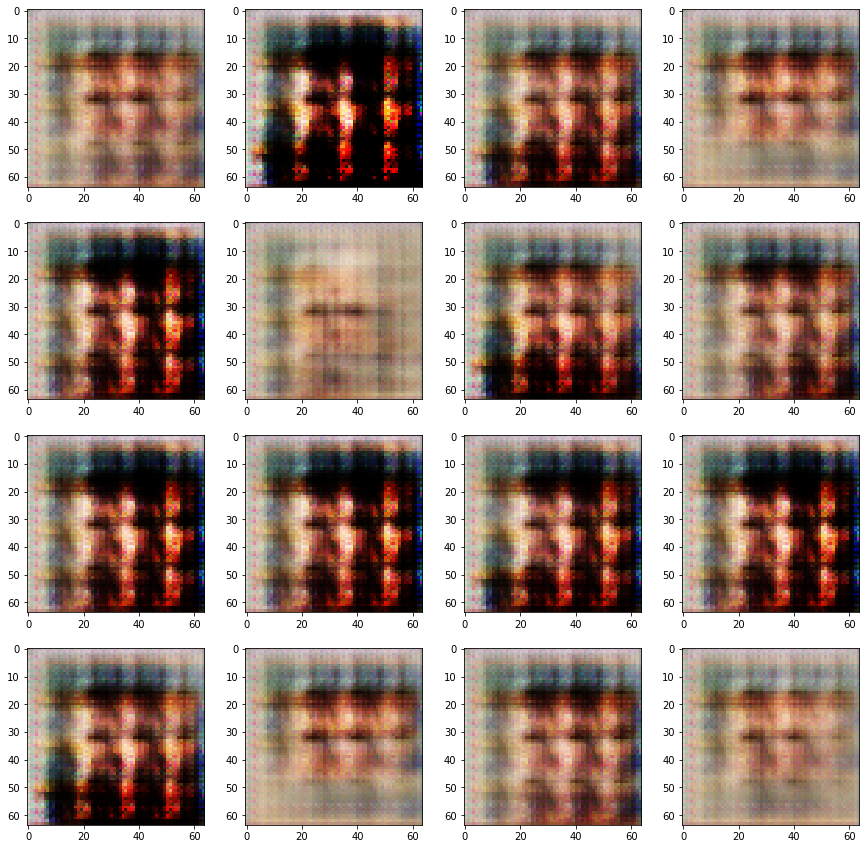

In [24]:
# 10 epochs

random_plotter(predictions_bgr)

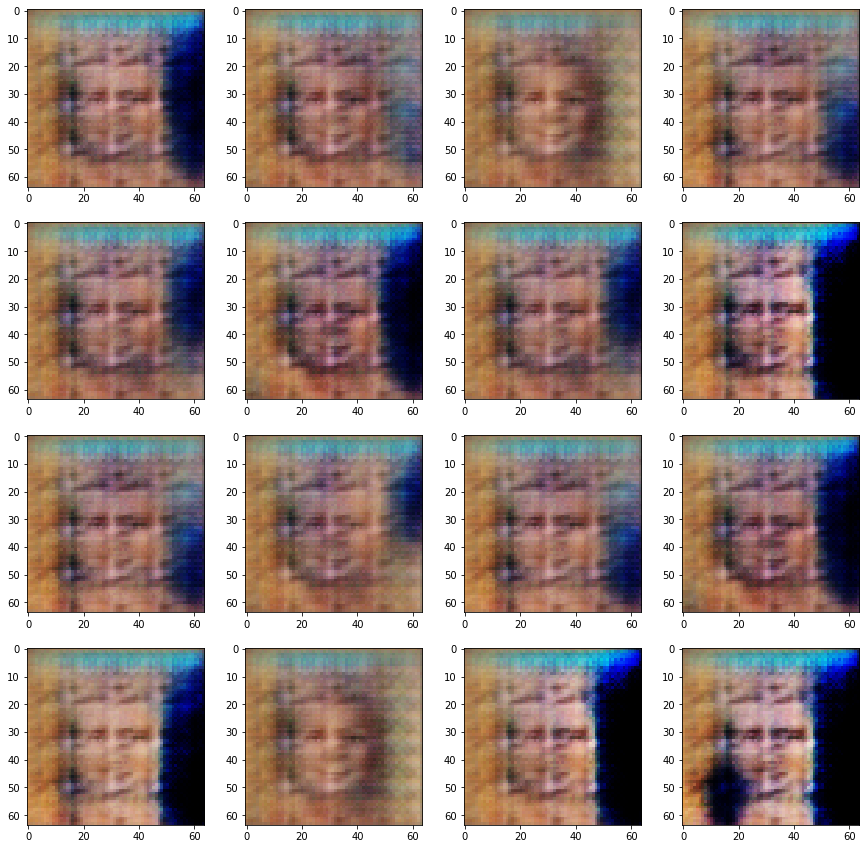

In [28]:
# 20 epochs

random_plotter(predictions)

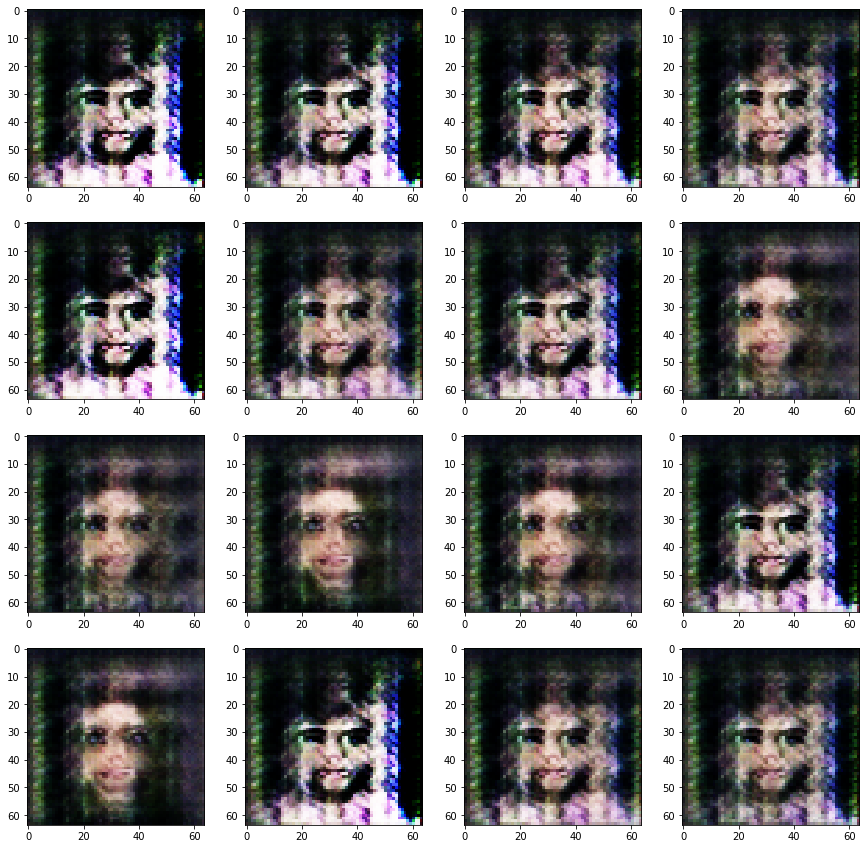

In [33]:
# 40 epochs

random_plotter(predictions)

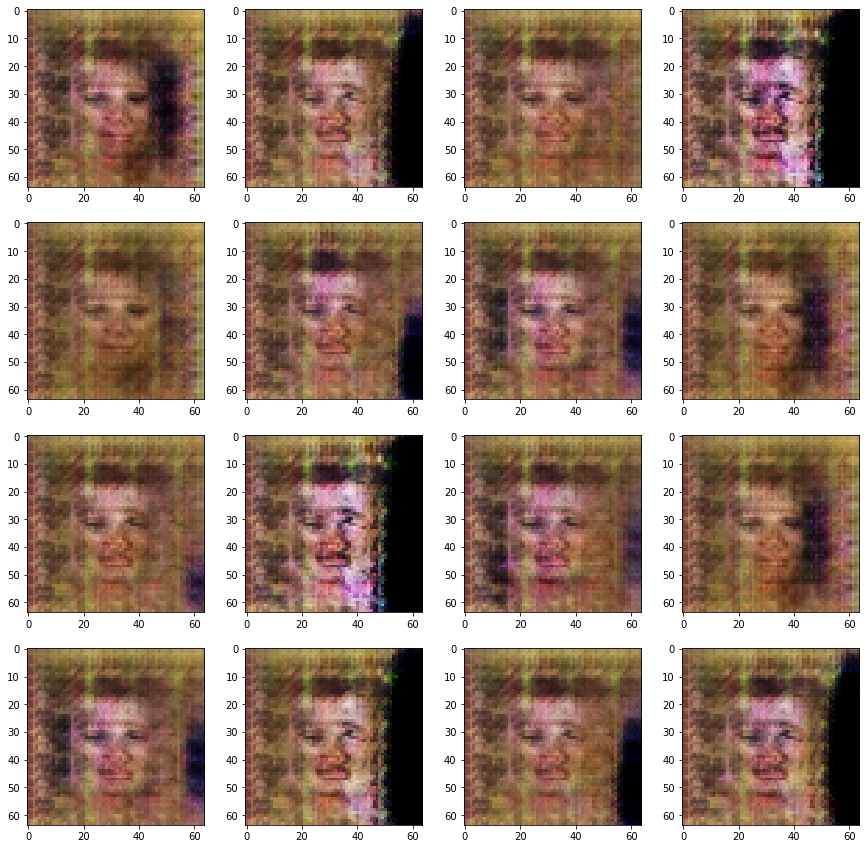

In [38]:
# 70 epochs

random_plotter(predictions)

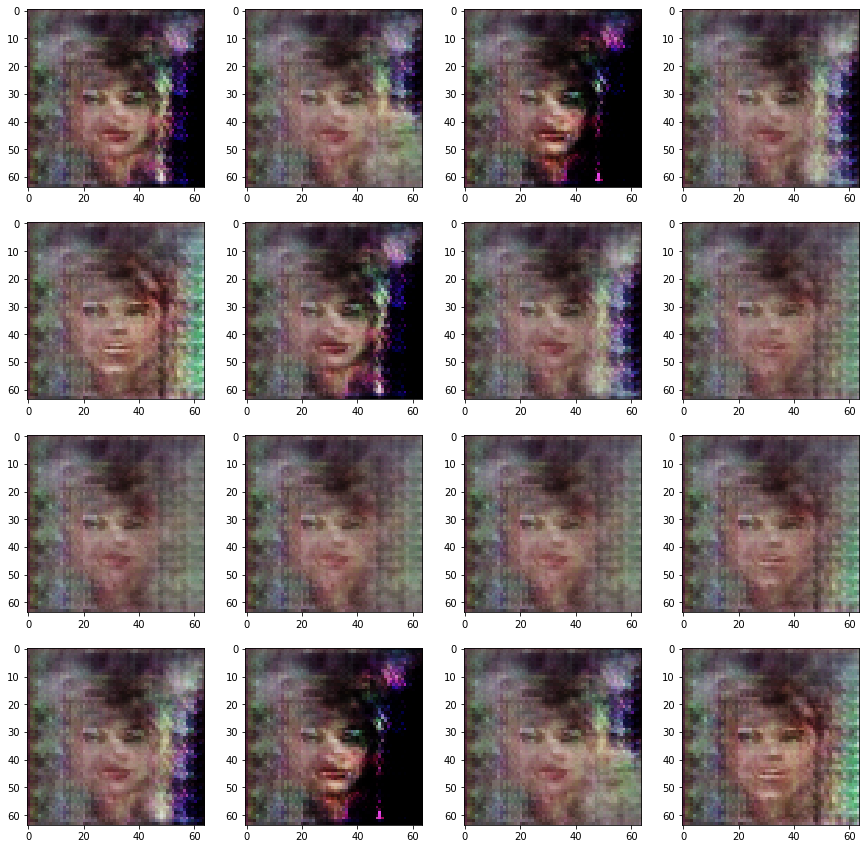

In [43]:
# 100 epochs

random_plotter(predictions)

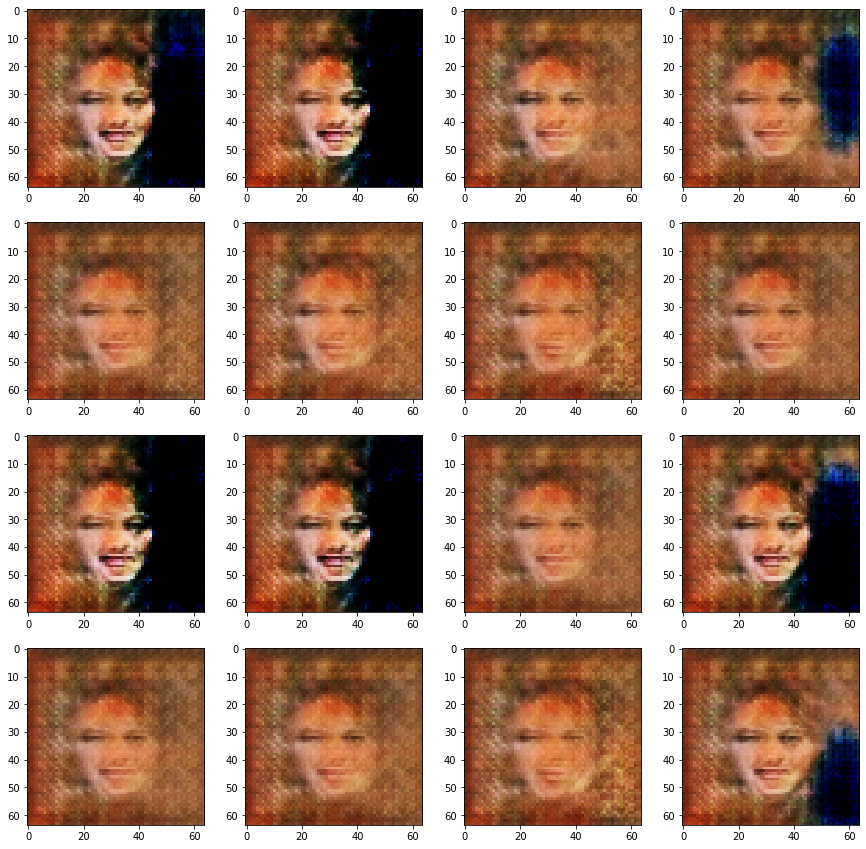

In [54]:
# 115 epochs

random_plotter(predictions)

In [69]:
# saving model

gan.save('/home/ksaver/Desktop/GAN/DCGAN_faces_model.h5', save_format='tf')